In [106]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using NearestNeighbors
include("LHI_Navier-stokes.jl")
using DoubleFloats
using Profile
using StatsBase

In [12]:
sample(1:100, 50; replace=false)

50-element Vector{Int64}:
 99
 76
 12
 79
 74
  9
 49
 91
 98
 61
  ⋮
 92
 39
 88
 57
 67
  1
 42
 75
 19

In [3]:
μ = 1.0
ρ = 1.0
@variables ϵ r x₁ x₂ u1 v1 u2 v2 ;
ϕ1 = r^7
ϕ2 = r^3

ϕ1 = substitute(ϕ1, r=>sqrt(x₁^2 + x₂^2))
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2))

∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))

Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ1)) ∂₁(∂₂(ϕ1)) 0; ∂₁(∂₂(ϕ1)) -∂₁(∂₁(ϕ1)) 0; 0 0 ϕ2])

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1x(x) =  -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3])  #+  u1*∂₁(x[1]) + v1*∂₂(x[1])
λ2x(x) =  -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3]) #+ u1*∂₁(x[2]) + v1*∂₂(x[2])
λ3x(x) = x[1]
λ4x(x) = x[2]

λ1y(x) =  -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3]) #- u2*∂₁(x[1]) - v2*∂₂(x[1])
λ2y(x) =  -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3]) #-u2*∂₁(x[2]) - v2*∂₂(x[2])
λ3y(x) = x[1]
λ4y(x) = x[2]

display(Φ_div)

F_A = construct_kernel_array(Φ_div,[λu,λv,λ1x,λ2x,λ3x,λ4x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
compile_kernel_array_NS(F_A,:F_A)


F_B = construct_kernel_array(Φ_div,[λ1x,λ2x],[λu,λv,λ1y,λ2y,λ3y,λ4y])

compile_kernel_array_NS(F_B,:F_B)

P_list2D = generate_2D2_div_free_poly_basis(4)
P_list1D = generate_2D1_poly_basis(2)
P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end
#display(P_list)
N_poly = length(P_list)
F_PA = apply_functionals_to_polynomials([λu,λv,λ1x,λ2x,λ3x,λ4x],P_list)
display(F_PA)
compile_polynomials_NS(F_PA,:F_PA)

F_PB = apply_functionals_to_polynomials([λ1x,λ2x],P_list)
#display(F_PB)
compile_polynomials_NS(F_PB,:F_PB)


println("done")

3×3 Matrix{Num}:
 -7(sqrt(x₁^2 + x₂^2)^5) - 35(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)  …                    0
                            35x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                       0
                                                        0     sqrt(x₁^2 + x₂^2)^3

6×25 Matrix{Num}:
 1    x₂     x₁    x₂^2             x₁*x₂    …  0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0  (-1//2)*(x₂^2)       0.0  0.0    0.0   0.0    0.0
 0.0   0.0    0.0    -2.0               0.0     0.0  1.0    0.0  x₂    2x₁
 0.0   0.0    0.0     0.0               1.0     1.0  0.0  2x₂    x₁      0.0
 1    x₂     x₁    x₂^2             x₁*x₂       0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0  (-1//2)*(x₂^2)    …  0.0  0.0    0.0   0.0    0.0

done


3120 3121 320

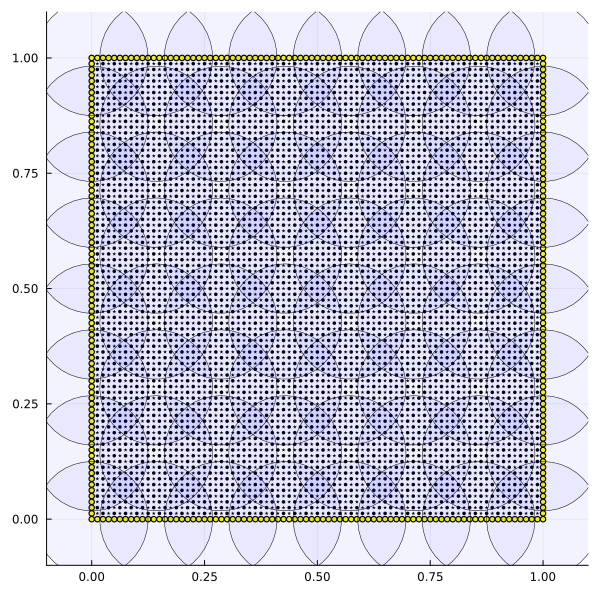

In [199]:
function circle(x,y,r)
    phi = LinRange(0,2*π,40)
    return x .+ r*sin.(phi), y .+ r*cos.(phi)
end
function plot_circles!(points,r)
    for i in 1:size(points)[2]
    x = points[1,i]
    y = points[2,i]
    plot!(circle(x,y,r),seriestype = [:shape,],linecolor=:black,legend=false,c =:blue,fillalpha = 0.05,linewidth= 0.5)
end
end
N_coll = 81
N_pu = floor(Int,N_coll/10)
r_pu = 1/N_pu

Total_internal_points,B_points = generate_2D_equally_spaced_points(N_coll)
N_total_I = size(Total_internal_points)[2]
PU_points = hcat(generate_2D_equally_spaced_points(N_pu)...)
L_points_indices = sample(1:N_total_I, floor(Int,N_total_I/2); replace=false)
L_points_indices = (1:N_total_I)[1:2:N_total_I]
L_points = Total_internal_points[:,L_points_indices]
I_points = Total_internal_points[:,setdiff(1:N_total_I,L_points_indices)]
All_points = hcat(I_points,L_points,B_points)
#display(I_points)
N_B = size(B_points)[2]
N_I = size(I_points)[2]
N_L = size(L_points)[2]
N_PU = size(PU_points)[2]
println(N_I, " ",N_L, " ",N_B)

scatter(I_points[1,:],I_points[2,:],markersize = 2,markercolor = :black,size=(600,600),lims=[-0.1,1.1])
scatter!(L_points[1,:],L_points[2,:],markersize = 2,markercolor = :black,markershape = :star)
scatter!(B_points[1,:],B_points[2,:],markersize = 3,markercolor = :yellow)
plot_circles!(PU_points,r_pu)
plot!()

In [200]:
@variables x y;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))

u = -y*sin(x^2 + y^2)
v = x*sin(x^2 + y^2)
p = sin(x-y)

#u = 20*x*y^3
#v = 5*x^4 - 5*y^4
#p = 60*x*x*y - 20*y*y*y 
display(dx(u)+dy(v))
f1 = -(μ/ρ)*(dx(dx(u)) + dy(dy(u))) + dx(p)/ρ
f2 = -(μ/ρ)*(dx(dx(v)) + dy(dy(v))) + dy(p)/ρ
display(f1)
display(f2)
f1 = eval(build_function(f1,x,y))
f2 = eval(build_function(f2,x,y))
true_v1 = eval(build_function(u,x,y))
true_v2 = eval(build_function(v,x,y))
f1(12,2)
function gu(x,y)
    """
    if abs(y-1) < 1e-10 
        return 1#-(0.5-x)^2 + 0.25
    else
        return 0.0
    end
    """
    return true_v1(x,y)
end
gv(x,y) = true_v2(x,y)
gu(0.9,1)

0

8.0y*cos(x^2 + y^2) + cos(x - y) - 4.0(y^3)*sin(x^2 + y^2) - 4.0y*(x^2)*sin(x^2 + y^2)

4.0(x^3)*sin(x^2 + y^2) + 4.0x*(y^2)*sin(x^2 + y^2) - cos(x - y) - 8.0x*cos(x^2 + y^2)

-0.9715269558223153

- build tree of all points 
- determine I,L, and B points for each PU patch
- construct matrix of shepard weights for I points 

for every patch
- construct A and B matrices depending on the points inside
- invert A, construct C matrix
- multiply each row of C by corresponding shepard weight
- multiply right part of C by local rhs and add to corresponding global RHS
- insert left part of C to Global matrix 

In [201]:
All_tree = KDTree(All_points,Euclidean(),leafsize = 3)
neigbours = inrange(All_tree, PU_points, r_pu, true)
Neighbours = Vector{Tuple{Vector{Int64},Vector{Int64},Vector{Int64}}}()
s = 0
max_neighbours = 0
for i in 1:N_PU
    I_lst = Vector{Int64}()
    L_lst = Vector{Int64}()
    B_lst = Vector{Int64}()
    if max_neighbours < length(neigbours[i]) max_neighbours = length(neigbours[i]) end
    for idx in neigbours[i]
        if idx <= N_I
            append!(I_lst,idx)
        elseif idx >= N_I+N_L+1
            append!(B_lst,idx-N_I-N_L)
        else
            append!(L_lst,idx-N_I)
        end
    end
    #println(I_lst,L_lst,B_lst)
    s =s+length(I_lst)+length(L_lst)+length(B_lst)
    append!(Neighbours,[(I_lst,L_lst,B_lst)])
end

Shep_matrix = pairwise(Euclidean(), I_points, PU_points, dims=2)
Shep_matrix .= wendland_C2.(Shep_matrix,r_pu)
Shep_matrix .= Shep_matrix ./ sum(Shep_matrix,dims=2)
display(Shep_matrix)
#typeof(V)
#append!(V,[([1,2],[3,4],[3,4,5,6])])
#Neighbours
println(max_neighbours)
println("done")

3120×64 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 ⋮                        ⋮              ⋱                          
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.806444    0.193556    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.12714     0.87286     0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

317
done


In [202]:
param = 0
A = zeros(max_neighbours*2+N_poly,max_neighbours*2+N_poly)
B = zeros(max_neighbours+10,max_neighbours*2+N_poly)
G = zeros(2N_I,2N_I)
G_RHS = vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:]))
U = zeros(2*N_I)
for i in 1:N_PU

    I_idx,L_idx,B_idx = Neighbours[i]

    PU_point = PU_points[:,i:i]
    Local_I_points = I_points[:,I_idx] .- PU_point
    Local_L_points = L_points[:,L_idx] .- PU_point
    Local_B_points = B_points[:,B_idx] .- PU_point
    N_I_loc = length(I_idx)
    N_L_loc = length(L_idx)
    N_B_loc = length(B_idx)
    N_tot_loc = N_I_loc+N_L_loc+N_B_loc
    L_RHS = vcat(f1.(L_points[1,L_idx],L_points[2,L_idx]),f2.(L_points[1,L_idx],L_points[2,L_idx]),
                gu.(B_points[1,B_idx],B_points[2,B_idx]),gv.(B_points[1,B_idx],B_points[2,B_idx]),zeros(N_poly))
    #display(L_RHS)
    range = (1:N_I_loc, N_I_loc+1:2N_I_loc, 2N_I_loc+1:2N_I_loc+N_L_loc, 2N_I_loc+N_L_loc+1:2N_I_loc+2N_L_loc,
            2N_I_loc+2N_L_loc+1:2N_I_loc+2N_L_loc+N_B_loc, 2N_I_loc+2N_L_loc+N_B_loc+1:2N_I_loc+2N_L_loc+2N_B_loc)
    L_point_list = (Local_I_points,Local_I_points,Local_L_points,Local_L_points,Local_B_points,Local_B_points)
    u_L = zeros(N_L_loc)
    v_L = zeros(N_L_loc)
    u_I = zeros(N_I_loc)
    v_I = zeros(N_I_loc)
    u_B = zeros(N_B_loc)
    v_B = zeros(N_B_loc)
    u_list = (u_I,u_I,u_L,u_L,u_B,u_B)
    v_list = (v_I,v_I,v_L,v_L,v_B,v_B)

    for j in 1:6
        if isempty(L_point_list[j])
            continue
        end
        for i in 1:j
            sym = Symbol(:F_A,i,j)
            #eval(:(func = $sym))
            apply_NS!(view(A,range[i],range[j]),L_point_list[i],L_point_list[j],u_list[i],v_list[i],u_list[j],v_list[j],eval(sym),param)
        end
        # polynomial part
        for i in 1:N_poly
            f = eval(Symbol(:F_PA,j,i))
            for k in 1:length(range[j])
                idx = range[j][k]
                p =  L_point_list[j][:,k]
                u = u_list[j][k]
                v = v_list[j][k]
                A[idx,2N_I_loc+2N_L_loc+i+2N_B_loc] = f(p[1],p[2],u,v)
                
                #PP[idx,j] = f(p[1],p[2],u,v)
            end
        end
    end

    for j in 1:6
        if isempty(L_point_list[j])
            continue
        end
        sym1 = Symbol(:F_B,1,j)
        sym2 = Symbol(:F_B,2,j)
        apply_NS!(view(B,range[1],range[j]),Local_I_points,L_point_list[j],u_I,v_I,u_list[j],v_list[j],eval(sym1),param)
        apply_NS!(view(B,range[2],range[j]),Local_I_points,L_point_list[j],u_I,v_I,u_list[j],v_list[j],eval(sym2),param)
    end
    for j in 1:N_poly
        for i in 1:2
            for k in 1:length(range[i])
                idx = range[i][k]
                f = eval(Symbol(:F_PB,i,j))
                p =  L_point_list[i][:,k]
                u = u_list[i][k]
                v = v_list[i][k]
                B[idx,2N_I_loc+2N_L_loc+2N_B_loc+j] = f(p[1],p[2],u,v)
                #PP[idx,j] = f(p[1],p[2],u,v)
            end
        end
        #print(" ",j)
    end


    A .= Symmetric(A,:U)
    #println(rank(A[1:2N_I_loc+2N_L_loc,1+2N_I_loc+2N_L_loc:2N_I_loc+2N_L_loc+N_poly]))
    #println(cond(A[1:2N_tot_loc+N_poly,1:2N_tot_loc+N_poly]),"  ",i," ",N_B_loc)
    C = B[1:2N_I_loc,1:2N_tot_loc+N_poly] * inv(view(A,1:2N_tot_loc+N_poly,1:2N_tot_loc+N_poly)) 
    
    SH = Shep_matrix[vcat(I_idx,I_idx),i:i]
    C .= C .* SH
    #display(SH)
    #display(C .* SH)

    G[vcat(I_idx,I_idx .+ N_I),vcat(I_idx,I_idx .+ N_I)] .+= C[:,1:2*N_I_loc]
    #println(size(C[:,1+2*N_I_local:end]),size(RHS))
    G_RHS[vcat(I_idx,I_idx .+ N_I)] .+= -(C[:,2*N_I_loc+1:end] * L_RHS) 
    #fill!(A,0.0)
end
display(sparse(G))
cond(G)

6240×6240 SparseMatrixCSC{Float64, Int64} with 3209872 stored entries:
⎡⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⣿⣿⣿⣿⣿⣧⣤⣤⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣧⣤⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠿⠿⠿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠿⠿⠿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠉⠉⠉⣿⣿⣿⣿⣿⣷⣶⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠉⣿⣿⣿⣿⣿⣷⣶⣶⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠿⠿⢿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠿⠿⢿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣶⣶⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣶⣶⣶⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⠛⢻⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠛⠛⢻⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⣿⣿⣿⣿⣿⣧⣤⣤⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣧⣤⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠿⠿⠿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠿⠿⠿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣷⣶⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣷⣶⣶⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠿⠿⢿⣿⣿⣿⣿⣿⣀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠿⠿⢿⣿⣿⣿⣿⣿⣀⣀⣀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣶⣶⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣶⣶⣶⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⠛⢻⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠛⠛⢻⣿⣿⣿⣿⣿⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎦

86587.18099440091

[-1.9531248013178574e-5, -0.00013281234381999125, -0.00043359133468077885, -0.0010156075399027741, -0.0019725743700527857, -0.003398146767925536, -0.005385868150779412, -0.008029091742902724, -0.011420871205456599, -0.015653815500712424, -0.020819902975000876, -0.027010249714428208, -0.034314827325963144, -0.042822125430860246, -0.052618754335277046, -0.06378898357273738, -0.07641421230378401, -0.09057236791927463, -0.10633722963529002, -0.12377767439986569, -0.14295684306525766, -0.1639312255247988, -0.18674966438102936, -0.21145227771178324, -0.23806930264273693, -0.2666198627271455, -0.2971106635834006, -0.3295346228543669, -0.3638694423328599, -0.4000761320463336, -0.4380974982091293, -0.4778566092272546, -0.5192552563694133, -0.5621724282850394, -0.6064628212363958, -0.651955409692611, -0.6984521047776803, -0.7457265309339082, -0.7935229540115376, -9.765624006589287e-6, -7.617182261944899e-5, -0.00028320215586920733, -0.0007246010928517455, -0.001494096699744437, -0.00268537613578

, -0.4719675703915285, -0.512570687564778, -0.5546899640063901, -0.5981875282659745, -0.6429004734468802, -0.688639514972036, -0.7351877567133779, -0.7822995974034925, -0.8296998120039789, -0.000675698955411301, -0.0014451112314707738, -0.002401932969901349, -0.003639820830107029, -0.0052523594387615564, -0.007333013474461277, -0.009975059278451553, -0.013271490898035358, -0.01731489549470773, -0.022197293088278194, -0.028009935665969102, -0.03484306076720125, -0.04278559476673616, -0.05192480122799853, -0.0623458698924064, -0.07413144211768614, -0.08736106888733558, -0.10211059789401905, -0.11845148666155822, -0.136450039223457, -0.15616656453086553, -0.17765445552986725, -0.20095918873707902, -0.2261172451635118, -0.25315495459848, -0.28208726657615796, -0.31291645281392977, -0.34563074753907036, -0.38020293391156196, -0.4165888867064655, -0.45472608353673694, -0.49453209917062396, -0.5359030999167096, -0.5787123575994929, -0.6228088053091732, -0.6680156598552408, -0.7141291386524689

, -0.3036212561924065, -0.33429044025269544, -0.36673645437580576, -0.40092841258746487, -0.4368187517611629, -0.47434181168273154, -0.513412402471938, -0.553924375946374, -0.5957492199599332, -0.6387346972974054, -0.6827035533331186, -0.7274523193339416, -0.772750240967523, -0.8183383642205998, -0.863928813487194, -0.0024530776655191516, -0.0049994442414175305, -0.007732329807956428, -0.010744841685041615, -0.01412989030776464, -0.01798009982644645, -0.022387698371114016, -0.027444382952289948, -0.03324115401580471, -0.039868114732960855, -0.047414230193455906, -0.05596704178241594, -0.06561233217083488, -0.07643373653746982, -0.08851229587727488, -0.10192594854481943, -0.11674895653941379, -0.13305126347088017, -0.15089778166042053, -0.17034760643943225, -0.19145315642004002, -0.21425923933410485, -0.23880204398174937, -0.26510805990469716, -0.29319292761181937, -0.3230602235409759, -0.3547001854478079, -0.388088385572061, -0.4231843607465025, -0.45993021058107486, -0.498249176970979

 -0.10819764887271494, -0.12337380980754395, -0.14001894983598018, -0.1581964411530343, -0.17796369165479903, -0.19937128168045432, -0.22246202749392943, -0.2472699722084035, -0.2738193059424885, -0.30212321821964017, -0.33218268698854775, -0.36398521015688323, -0.39750348719696227, -0.4326940602003573, -0.4694959257274187, -0.507829130911879, -0.5475933695314297, -0.5886665961293531, -0.6309036787521717, -0.6741351134307676, -0.7181658261486414, -0.7627740906756528, -0.8077105932566957, -0.8526976776830275, -0.0015293616225307233, -0.004634604106108691, -0.007879367976271385, -0.011356543850969566, -0.015158827990886725, -0.019378626774925307, -0.024107943427285033, -0.029438241976288214, -0.03546028346992236, -0.04226392953501148, -0.0499379084502635, -0.05856953901318534, -0.06824440762274092, -0.0790459941800782, -0.0910552426357471, -0.10435007229125218, -0.11900482630375736, -0.13508965425396857, -0.15266982612771376, -0.17180497564082386, -0.19254827151399692, -0.214945516088761

, -0.13849641749557962, -0.1549034152045625, -0.17263095397167005, -0.1917363722910058, -0.21227079492044282, -0.2342783149075274, -0.2577951109950928, -0.2828485012968763, -0.309455935171923, -0.3376239263894441, -0.36734693196851365, -0.3986061825035982, -0.4313684713497022, -0.46558491174009786, -0.5011896727428369, -0.5380987069242203, -0.5762084846694622, -0.6153947523002761, -0.6555113334091501, -0.6963889951787763, -0.7378344038453416, -0.779629195863214, -0.8215291936967603, -0.8632637974568865, -0.9045355857626952, -0.0030944418599966423, -0.009328734272738249, -0.015699179764783983, -0.022296301244179244, -0.029210244223104746, -0.03653060852886082, -0.04434626274762352, -0.05274513656171509, -0.0618139862180991, -0.07163812846683655, -0.08230113843744032, -0.09388450708325508, -0.10646725402464516, -0.12012549186698936, -0.13493193836593367, -0.1509553731672102, -0.16826003626920216, -0.18690496585126073, -0.20694327368771748, -0.2284213570348392, -0.25137804664382185, -0.27

, -0.23540398085536454, -0.25738678242099094, -0.2806228024634863, -0.30513693214637055, -0.33094486442068405, -0.35805215764685633, -0.38645325357128585, -0.4161304544458953, -0.4470528654350903, -0.47917530992824164, -0.5124372269656696, -0.5467615616883985, -0.5820536615301131, -0.6182001927740184, -0.6550680940843487, -0.6925035856746055, -0.7303312548703891, -0.7683532409371252, -0.8063485441400174, -0.8440724860475668, -0.8812563500373516, -0.9176072327638096, -0.9528081389464884, -0.005127305052445106, -0.01542465325127001, -0.02585009511557682, -0.036488622033348156, -0.04742461064992622, -0.05874156069611053, -0.07052181664403949, -0.08284626872021787, -0.09579402892343805, -0.10944207784652227, -0.12386487828859405, -0.13913395187338934, -0.15531741516393072, -0.1724794720902075, -0.19067985989027975, -0.20997324621275776, -0.23040857554647637, -0.2520283637381192, -0.2748679400372886, -0.29895463687769863, -0.3243069284690832, -0.3509335202428797, -0.37883239227083726, -0.40

-0.12016479115845687, -0.13533488243714378, -0.15137680313329605, -0.16835558761012273, -0.1863319936825949, -0.2053619192742667, -0.22549577000337512, -0.24677777625587222, -0.2692452589477189, -0.29292784391055243, -0.31784662566002836, -0.3440132822306277, -0.3714291437897462, -0.4000842188818201, -0.4299561834033165, -0.46100933877340877, -0.4931935472431338, -0.5264431538757143, -0.5606759064280402, -0.5957918861606943, -0.6316724644907754, -0.6681793023639179, -0.7051534112409843, -0.742414296648177, -0.7797592072991143, -0.8169625148308561, -0.8537752511645186, -0.8899248323606715, -0.925114999539902, -0.9590260089232696, -0.00550204932561853, -0.01654822494972544, -0.02772050209994323, -0.039102514853765785, -0.05077723884776153, -0.0628267118856106, -0.0753317386403905, -0.08837157506685187, -0.10202358826539952, -0.11636288769983426, -0.13146192386935443, -0.1473900507761905, -0.16421304881842957, -0.18199260507844162, -0.20078574837663454, -0.22064423692415136, -0.2416138969

, -0.26921256526542625, -0.29250096714599233, -0.316694847901474, -0.3418078159540971, -0.36784451645327837, -0.3947998139127105, -0.4226579454122768, -0.4513916489522006, -0.48096127274098477, -0.5113138724863223, -0.5423823051369324, -0.574084328988866, -0.6063217216154773, -0.638979428696533, -0.6719247584963357, -0.7050066384573493, -0.7380549521150119, -0.7708799762774485, -0.8032719401225884, -0.8350007295119595, -0.8658157613675551, -0.8954460543629575, -0.9236005233945199, -0.9499685262699324, -0.9742206917219435, -0.007867503884385051, -0.023638918887191718, -0.039519370818364, -0.05558093306402261, -0.07189474522495035, -0.08853062579620369, -0.10555667119571553, -0.12303883746624003, -0.14104050114843686, -0.1596219960403137, -0.17884012282277936, -0.19874762884629732, -0.2193926557435581, -0.24081815296200815, -0.26306125580253137, -0.28615262711123124, -0.3101157624047965, -0.33496625892090603, -0.36071104987780417, -0.3873476061054069, -0.41486310817723354, -0.44323359323

, -0.5181674661603424, -0.5469274956863183, -0.5758997751603054, -0.6049837884110275, -0.6340641031964709, -0.6630097809337266, -0.6916738549000745, -0.7198928927696127, -0.7474866607515527, -0.7742579079560772, -0.7999922909026753, -0.8244584592714843, -0.8474083250435677, -0.8685775380403659, -0.8876861915107248, -0.9044397817769628, -0.9185304459866758, -0.9296385016683658, -0.010173371205276123, -0.030547326363234994, -0.05100268104171539, -0.07159290436576392, -0.09237026446062414, -0.11338533780313757, -0.13468650852368944, -0.15631945507414743, -0.17832662189593187, -0.20074667399359072, -0.22361393264524554, -0.2469577908644938, -0.2708021076714604, -0.29516458073643265, -0.3200560975306419, -0.34548006575789025, -0.37143172455022916, -0.39789743869274724, -0.4248539789980984, -0.4522677928813476, -0.48009427018970624, -0.5082770104182955, -0.5367470985893334,

 -0.5654223982835611, -0.5942068715828792, -0.6229899370034732, -0.6516458778581191, -0.6800333148711509, -0.7079947582630063, -0.7353562559033796, -0.7619271554793726, -0.7874999999104968, -0.8118505764349528, -0.8347381408563144, -0.8559058393375002, -0.8750813508166875, -0.8919777735505356, -0.906294779413031, -0.9177200593392842, -0.9259310826456579, -0.02070350120174845, -0.041459478453255844, -0.06231992181485193, -0.08333584651151787, -0.10455679842195323, -0.1260303511904778, -0.14780159239526092, -0.16991259640255954, -0.19240188178502712, -0.2153038514847024, -0.23864821426025026, -0.26245938637585636, -0.2867558729684517, -0.3115496290732542, -0.3368454008974873, -0.36264004861086385, -0.3889218526709644, -0.4156698065234351, -0.4428528994117266, -0.4704293939987877, -0.4983461045424961, -0.5265376824751621, -0.5549259174111122, -0.5834190628393247, -0.6119111970424453, -0.6402816311090651, -0.6683943772600937, -0.6960976920767947, -0.723223710578806, -0.7495881884331723, -0

, 0.03653060852886082, 0.0399150561142054, 0.043436402824245726, 0.04708789784057589, 0.0508618716108676, 0.05474966527551718, 0.05874156069611053, 0.0628267118856106, 0.06699307873052726, 0.07122736398889808, 0.07551495464374765, 0.07983986878866456, 0.08418470931888251, 0.08853062579620369, 0.09285728594743653, 0.09714285834167816, 0.10136400786943575, 0.10549590571367655, 0.10951225555659755, 0.11338533780313757, 0.003398146767925536, 0.003585595943960547, 0.0039604771956712245, 0.004522751929271616, 0.005272351272477933, 0.006209162899992379, 0.007333013474461277, 0.00864364671148343, 0.01014069708262815, 0.011823659177962176, 0.013691852759706453, 0.015744383551769287, 0.01798009982644645, 0.0203975448699464, 0.0229949054329823, 0.025769956301845136, 0.028720001159486228, 0.031841809945512965, 0.035131552968923646, 0.038584732078115073, 0.04219610924937207, 0.04595963301781005, 0.04986836324362832, 0.05391439478148927, 0.05808878070171093, 0.0623814557984639, 0.06678116121188524, 

, 0.17288044602256503, 0.18151055042157116, 0.19014655662582222, 0.19874762884629732, 0.2072699431886042, 0.2156666731214816, 0.22388800296532435, 0.23188117285549514, 0.23959055872061383, 0.2469577908644938, 0.027010249714428208, 0.027383705519412906, 0.02813048818482163, 0.029250331070688522, 0.03074281234726043, 0.03260732877255192, 0.03484306076720125, 0.037448928824457925, 0.04042354130903126, 0.04376513371870476, 0.04747149950791124, 0.051539912603690265, 0.05596704178241594, 0.06074885712116872, 0.06588052879137282, 0.07135631852503328, 0.07716946415623015, 0.08331205772304083, 0.08977491770825903, 0.0965474561015574, 0.10361754108137103, 0.11097135624189294, 0.11859325742913696, 0.12646562839980324, 0.13456873667723432, 0.14288059114936777, 0.15137680313329605, 0.16003045281853343, 0.16881196319472205, 0.1776889837672527, 0.18662628656369767, 0.19558567713216685, 0.20452592342635348, 0.21340270565728953, 0.22216859036431488, 0.23077303211260347, 0.23916240635636438, 0.247280077

 0.2708021076714604, 0.034314827325963144, 0.03471877962863597, 0.035526520858632664, 0.036737714800188066, 0.03835183347619687, 0.040368128790785614, 0.04278559476673616, 0.04560292042390678, 0.04881843336329693, 0.052430034144523394, 0.05643512157312163, 0.06083050904914148, 0.06561233217083488, 0.07077594783766844, 0.07631582515623335, 0.08222542852161498, 0.08849709332611186, 0.09512189483746937, 0.10208951089053356, 0.10938807914984423, 0.11700404982644212, 0.12492203487018275, 0.13312465480906038, 0.14159238456916876, 0.1503033997824446, 0.15923342527345738, 0.16835558761012273, 0.1776402738048849, 0.18705499846081275, 0.196564281868946, 0.20612954177644138, 0.21570900175643287, 0.22525761931637558, 0.23472703707779, 0.24406556054200437, 0.2532181661184044, 0.2621265432279511, 0.27072917439888594, 0.2789614573366342, 0.2867558729684517, 0.03856984492470362, 0.039198443363101416, 0.04024580009825135, 0.04171143695497824, 0.04359465014298931, 0.04589447595737941, 0.0486096467489063

 0.2228266249849827, 0.23376025148233923, 0.24504164651500826, 0.2566375690826093, 0.2685113698701115, 0.2806228024634863, 0.29292784391055243, 0.30537852782092284, 0.31792279347942587, 0.3305043547284601, 0.3430625926521545, 0.35553247636391766, 0.36784451645327837, 0.37992475588138414, 0.3916948033199298, 0.40307191409769894, 0.4139691240436039, 0.42429544158571325, 0.43395610347219615, 0.4428528994117266, 0.11506598464045732, 0.11595401760317908, 0.1174331651094765, 0.11950204174849231, 0.12215865947248754, 0.125400379253874, 0.1292238491214894, 0.13362492873096043, 0.13859860067080768, 0.14413886876012016, 0.15023864365642547, 0.15688961616503078, 0.16408211872476633, 0.17180497564082386, 0.1800453427442535, 0.18878853728056053, 0.19801785896750387, 0.20771440331525626, 0.2178568684709808, 0.2284213570348392, 0.23938117449544324, 0.25070662614950395, 0.26236481460228256, 0.27431944019142335, 0.28653060693544063, 0.29895463687769863, 0.3115438959747849, 0.32424663496185385, 0.337006

, 0.2752258034483455, 0.28131982414533246, 0.2880931744401195, 0.295532205435378, 0.3036212561924065, 0.31234248803639714, 0.3216757066582541, 0.3315981731699815, 0.3420844054469013, 0.3531059712830468, 0.3646312750964038, 0.3766253401483632, 0.3890495884866224, 0.40186162108225915, 0.4150150009088562, 0.4284590420029473, 0.44213860784876374, 0.45599392274379213, 0.4699604001219293, 0.4839684921342434, 0.4979435651090772, 0.5118058058282029, 0.5254701638579156, 0.5388463354564804, 0.5518387948344511

, 0.5643468787634824, 0.5762649307028438, 0.5874825107305841, 0.5978846776170265, 0.6073523493500665, 0.6157627483020301, 0.6229899370034732, 0.2666198627271455, 0.26736065635534684, 0.26884098920199895, 0.27105833510487204, 0.27400886153290704, 0.2776873778361589, 0.28208726657615796, 0.28720039823008864, 0.29301702964816345, 0.29952568673785046, 0.30671303195270905, 0.3145637172789672, 0.3230602235409759, 0.33218268698854775, 0.3419087142860189, 0.35221318719559364, 0.3630680584368719, 0.37444214041091994, 0.3863008887010542, 0.3986061825035982, 0.4113161043998129, 0.42438472215418016, 0.4377618755129675, 0.4513929712787706, 0.4652187902492086, 0.47917530992824164, 0.4931935472431338, 0.5071994258246352, 0.5211136727275244, 0.5348517497773982, 0.5483238250209268, 0.5614347900231951, 0.574084328988866, 0.586167045874476, 0.597572655797083, 0.6081862471187804, 0.6178886205855088, 0.626556711809695, 0.6340641031964709, 0.6402816311090651, 0.2819038968130921, 0.2830275197176234, 0.284898

, 0.7408695536351789, 0.7516653435502979, 0.7617104910880472, 0.7708799762774485, 0.7790442101388648, 0.7860694576378209, 0.7918183512279551, 0.7961505013149195, 0.7989232096166465, 0.7999922909026753, 0.7992130079517556, 0.49865875006439647, 0.49986064651146916, 0.5018599000126045, 0.5046506169176549, 0.5082244807800144, 0.512570687564778, 0.5176758631315126, 0.5235239635965483, 0.5300961593305746, 0.5373707035077584, 0.5453227862940774, 0.553924375946374, 0.563144048290939, 0.5729468062621407, 0.5832938914084235, 0.594142589515297, 0.605446032752818, 0.6171530010282308, 0.6292077255121867, 0.6415496976081546, 0.6541134869475712, 0.6668285723157508, 0.6796191897426959, 0.6924042023252283, 0.7050969966780121, 0.7176054112360825, 0.7298317019445559, 0.7416725511656188, 0.7530191259010659, 0.7637571916621285, 0.7737672885076737, 0.7829249759067837, 0.7911011531510341, 0.7981624620334906, 0.8039717784127297, 0.8083887990776699, 0.8112707300086999, 0.8124730816782317, 0.8118505764349528, 0

 0.9176072327638096, 0.925114999539902, 0.9318772709721824, 0.9377688499997239, 0.9426598484514171, 0.9464160601261672, 0.9488994157498731, 0.9499685262699324, 0.9494793207376081, 0.9472857847041821, 0.9432408046046563, 0.9371971230088978, 0.929008408870701, 0.9185304459866758, 0.9056224417762437, 0.7698475316543837, 0.7709293713385555, 0.7727264127210123, 0.7752295892070625, 0.7784261490051291, 0.7822995974034925, 0.7868296237563089, 0.7919920140934551, 0.7977585504864683, 0.8040968985288153, 0.8109704845240125, 0.8183383642205998, 0.8261550851892627, 0.8343705452048172, 0.8429298492742929, 0.851773168241582, 0.8608356021982329, 0.870047052237627, 0.8793321044041871, 0.8886099300079567, 0.8977942067948793, 0.9067930657805992, 0.9155090688662285, 0.92383922265299, 0.9316750341529824, 0.9389026143486204, 0.9454028357758695, 0.9510515504876025, 0.9557198748837962, 0.9592745479644926, 0.9615783695583539, 0.9624907249922813, 0.9618682024833983, 0.9595653092405104, 0.9554352918444025, 0.949


max error: 0.008655576332979753


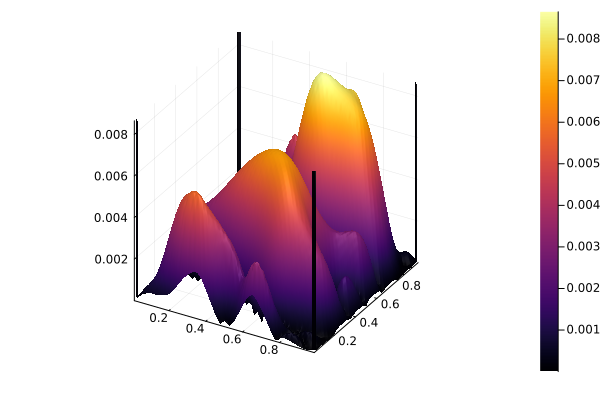

In [203]:
reference_v = vcat(true_v1.(I_points[1,:],I_points[2,:]),true_v2.(I_points[1,:],I_points[2,:]))

println(reference_v)
sol = sparse(G)\G_RHS
err = abs.(sol - reference_v)
println("max error: ",maximum(err))
#surface(I_points[1,:],I_points[2,:],reference_v[1:N_I])
#surface(I_points[1,:],I_points[2,:],sol[1:N_I])
surface(I_points[1,:],I_points[2,:],err[1:N_I])